# End-to-End Quantitative Strategy Workflow

This notebook demonstrates a complete end-to-end workflow for a quantitative trading strategy, including:

1.  **Factor Calculation**: Running a deep learning model to generate predictive factor scores.
2.  **Portfolio Optimization**: Converting raw factor scores into optimized portfolio weights using a layered optimizer.
3.  **Backtesting**: Simulating the strategy's historical performance using the generated weights and a high-performance Rust-based backtester.

## Step 0: Setup and Imports

First, we import all necessary libraries and custom modules. We also add the project's root directory to the system path to ensure that our custom modules (`longgang_trader`) can be found.

In [13]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import yaml
import torch
import json
import shutil

project_root = Path.cwd()
while not(project_root /'pyproject.toml').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to sys.path")

In [14]:

# Import custom modules using absolute imports (project_root is added to sys.path in an earlier cell).
from longgang_trader.alpha.dl_model_factor import inference_on_test_set, load_config
from longgang_trader.backtesting.backtester import Backtester,ensure_market_data_continuity
from longgang_trader.backtesting.strategy import RollingTopQuantileStrategy,SimpleWeightStrategy

print("Setup complete. All modules imported.")

Setup complete. All modules imported.


In [15]:
weights_df = pl.read_csv("../data/all_weight_atr.csv")


weights_df = weights_df.unpivot(
    index=[""],
    variable_name="code",
    value_name="weight"
).with_columns(
    pl.col('').cast(pl.Utf8).str.strptime(pl.Datetime, format="%Y%m%d").alias("date")
).drop([""])
weights_df = weights_df.with_columns(
    pl.when(pl.col("date")<pl.date(2023,9,26)).then(
        pl.lit(0.0)
    ).otherwise(pl.col("weight")).alias("weight")
)

In [16]:
config_strategy = {
    "rolling_window": 20,
    "quantile": 0.9,
    "min_score": 0.0,
    "date_col":"date",
    "symbol_col":"code",
    "weight_col":"weight",
}
strategy = SimpleWeightStrategy(factor_data=(weights_df).to_pandas(), config=config_strategy)

In [17]:
config_backtester = {
    "close_col": "close",
    "volume_col": "volume",
    "preclose_col": "preclose",
    "limit_pct": 0.1,
    "initial_capital": 1_000_000_000,
    "transaction_cost": 0.001,
    "rebalance_days": 1,
}
backtester = Backtester(strategy=strategy, data_path="../data/baostock_data_filled.parquet",config=config_backtester)


生成的交易信号 (Simple Weight Strategy):
总交易日数: 2857
总信号数: 15713500
权重列: weight
信号数据预览:
shape: (5, 3)
┌─────────────────────┬───────────┬──────────┐
│ date                ┆ code      ┆ weight   │
│ ---                 ┆ ---       ┆ ---      │
│ datetime[μs]        ┆ str       ┆ f64      │
╞═════════════════════╪═══════════╪══════════╡
│ 2025-04-07 00:00:00 ┆ 600601.SH ┆ 0.000363 │
│ 2025-04-08 00:00:00 ┆ 600601.SH ┆ 0.000639 │
│ 2025-04-09 00:00:00 ┆ 600601.SH ┆ 0.000941 │
│ 2025-04-10 00:00:00 ┆ 600601.SH ┆ 0.001331 │
│ 2025-04-11 00:00:00 ┆ 600601.SH ┆ 0.001606 │
└─────────────────────┴───────────┴──────────┘
Rust 回测成功完成。


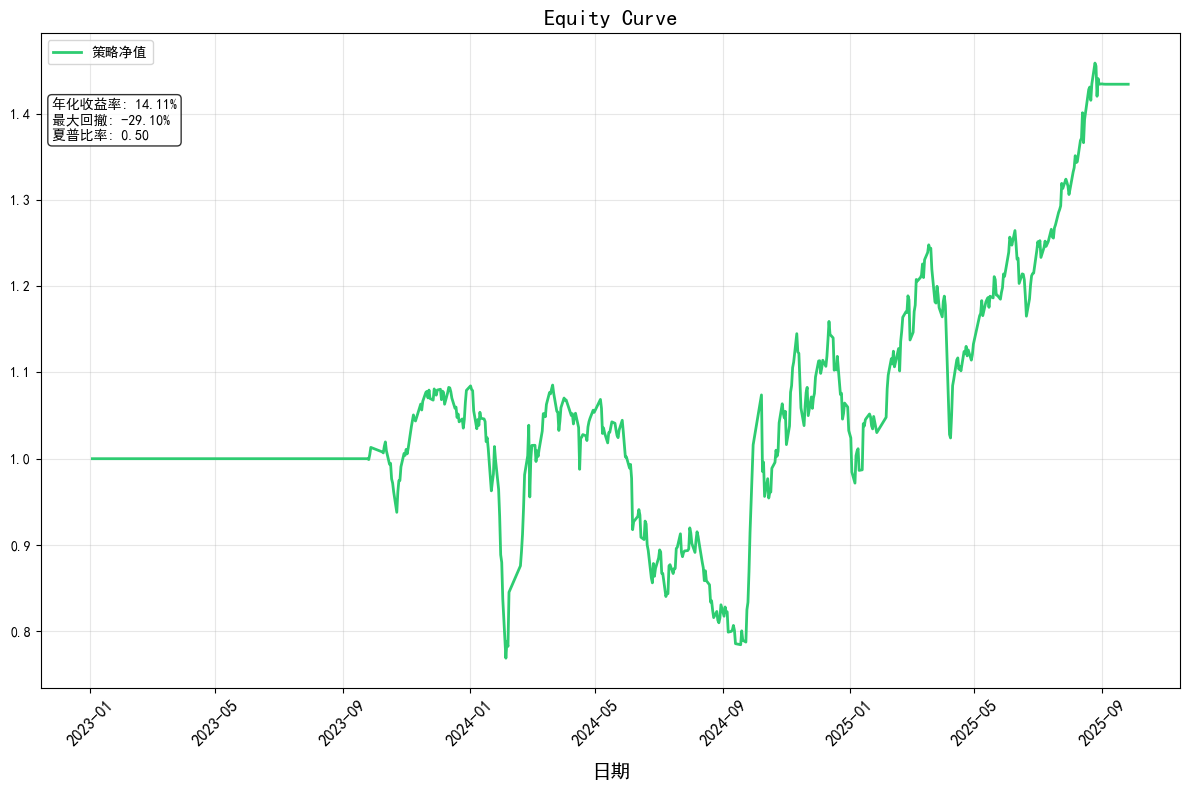

In [18]:
backtester.run_backtest()
backtester.plot_equity_curve()